## Imports & function definitions

In [1]:
import os 
os.chdir('/lustre/scratch/kiviaho/prostate_spatial/')

import scanpy as sc
import numpy as np
import pandas as pd
import anndata as ad
import squidpy as sq


from scipy.stats import fisher_exact
import matplotlib.pyplot as plt
from scripts.utils import load_from_pickle, get_sample_ids_reorder, get_sample_crop_coords, get_sample_id_mask, save_to_pickle
from statsmodels.stats.multitest import multipletests

from itertools import combinations
from scipy.stats import ranksums,kruskal

import seaborn as sns
sns.set_theme()

sc.set_figure_params(figsize=(6,6))

import warnings
warnings.filterwarnings("ignore")

samples = get_sample_ids_reorder()
sample_crop_coord = get_sample_crop_coords()
sample_id_masks = get_sample_id_mask()

sample_categories_dict = {
    'BPH':get_sample_ids_reorder('BPH'),
    'TRNA':get_sample_ids_reorder('untreated'),
    'NEADT':get_sample_ids_reorder(['goserelin','bicalutamide','degarelix','degarelix_apalutamide']),
    'CRPC': get_sample_ids_reorder('CRPC')
}

region_colors_dict = {
 'Tumor': '#fc8d62',
 'Luminal epithelium': '#8da0cb',
 'Basal epithelium': '#66c2a5',
 'Club epithelium': '#ffd92f',
 'Immune': '#a6d854',
 'Endothelium': '#e78ac3',
 'Fibroblast': '#e5c494',
 'Muscle': '#b3b3b3'
 }


## Downloading ligand-receptor interactions results

In [2]:
def get_ligrec_results(results_dict,source_region, target_region, pval = 0.05,reverse=False):
    # Function only reports those means that have a below-threshold p-value

    if reverse:
        source = source_region
        source_region = target_region
        target_region = source

    for i,s in enumerate(list(results_dict.keys())):
        means = results_dict[s]['means'][source_region][target_region]
        pvals = results_dict[s]['pvalues'][source_region][target_region]
        means = pd.DataFrame(means[pvals[pvals<pval].index])
        means = means.rename(columns={target_region:s})
        meta = results_dict[s]['metadata'].loc[means.index]

        if i==0:
            means_all = means
            metas_all = meta
        else:
            means_all = pd.merge(means_all,means,how='outer',left_index=True,right_index=True)
            metas_all = pd.concat([metas_all,meta],axis=0)

    # Drop duplicate indices
    metas_all.drop_duplicates(inplace=True)

    return pd.DataFrame(means_all), metas_all

def summarize_ligrec_results(ligrec_results,ligrec_meta,score_filter=10):
    ## Summarize the ligand-receptor pair results
    df_sum = ligrec_results.copy()
    n_samples = df_sum.shape[1]
    active_in = (~df_sum.isna()).sum(axis=1)
    mean_activity = df_sum.mean(axis=1)
    summarized_ligrec_results = pd.DataFrame({'mean':mean_activity,'active_in':active_in})

    # Included n_references filtering
    valid_meta = ligrec_meta[ligrec_meta['n_references']>= 3]
    
    summarized_ligrec_df = summarized_ligrec_results.loc[valid_meta.index.drop_duplicates()]

    # Add columns for ligands and receptors
    summarized_ligrec_df['ligand'] = summarized_ligrec_df.index.get_level_values(0)
    summarized_ligrec_df['receptor'] = summarized_ligrec_df.index.get_level_values(1)

    summarized_ligrec_df = summarized_ligrec_df.sort_values(summarized_ligrec_df.columns[1],ascending=False)

    return summarized_ligrec_df

def check_top_markers(r,p_thresh=0.05):
    # These results rank the deg significance and specificity (low p-value = good marker)
    deg_fishers_res_dict = load_from_pickle('./data/region_gene_markers_fishers_exact_test_240229.pkl')

    fishers_test_df = deg_fishers_res_dict[r].rename(columns={'interaction':'gene','active_in':'deg in'})
    fishers_test_df = fishers_test_df.sort_values('adj_pval').reset_index(drop=True)
    fishers_test_df = fishers_test_df[fishers_test_df['adj_pval'] < p_thresh]

    return fishers_test_df

# Run the function straight off
club_markers_df = check_top_markers('Club epithelium')
marker_genes = club_markers_df['gene'].tolist()


## Ligand-receptor interaction region-specific prevalences (Figure 4g)

### Club region as source with all other regions as target

In [3]:
interact_with = ['Tumor','Luminal epithelium','Basal epithelium','Immune','Fibroblast','Muscle'] # Endothelium excluded due to n

# Club as source in all samples
source = 'Club epithelium'

results_dict = {}
n_interfaces = {}
for target in interact_with:
    dat_dict = load_from_pickle('./data/region_ligrec_analysis/{}_{}_slides_with_ligrec.pkl'.format(source,target))
    
    ligrec_results_out,ligrec_meta_out = get_ligrec_results(dat_dict,source,target,reverse=False)

    summarized_df = summarize_ligrec_results(ligrec_results_out,ligrec_meta_out)
    summarized_df['interaction'] = target
    summarized_df['active_in'] = summarized_df['active_in']/len(dat_dict) # Define whether to normalize by the number samples with region interfaces

    results_dict[target] = summarized_df
    n_interfaces[target] = ligrec_results_out.shape[1]
    
club_as_source_ligrec = results_dict.copy()
total_n_interfaces = sum(n_interfaces.values())

In [5]:
# Format the data for plotting

# Only include genes that are marker genes in the Club region
df = pd.concat(club_as_source_ligrec)
df = df[df['ligand'].isin(marker_genes)]

ligands_to_include = df['ligand'].unique()

df = df[df['ligand'].isin(ligands_to_include)]
receptors = sorted(df['receptor'].unique())

df['interaction'] = df['interaction'].astype('category').cat.set_categories(interact_with)


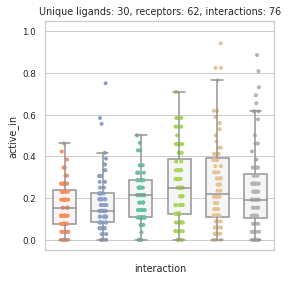

In [9]:

# Create a pivot table to check for missing interactions
pivot_df = df.pivot_table(index=['ligand', 'receptor'], columns='interaction', values='active_in', fill_value=0)

# Convert the pivot table back to a dataframe
result_df = pivot_df.stack().reset_index()
result_df.columns = ['ligand', 'receptor', 'interaction', 'active_in']

# Create a title with key numbers
title = 'Unique ligands: {}, receptors: {}, interactions: {}'.format(
    len(result_df['ligand'].unique()),
    len(result_df['receptor'].unique()),
    len((result_df['ligand']+'_'+result_df['receptor']).unique())
    )

# Plot the boxplot
sns.set_theme(
            style='whitegrid',
            font_scale=0.8
            )
sns.set_palette(palette=sns.color_palette([region_colors_dict[r] for r in interact_with]))

fig, ax = plt.subplots(figsize=(4,4))
sns.stripplot(result_df,x='interaction',y='active_in',size=4,hue='interaction',ax=ax,legend=False)
sns.boxplot(showmeans=False,
        meanline=False,
        meanprops={'color': 'k', 'ls': '-', 'lw': 2},
        medianprops={'visible': True},
        whiskerprops={'visible': True},
        zorder=10,
        x="interaction",
        y="active_in",
        data=result_df,
        showfliers=False,
        showbox=True,
        showcaps=True,
        color='whitesmoke',
        width=0.6,
        ax=ax)

ax.set_ylim(-0.05,1.05)
ax.set_xticklabels('')
ax.set_title(title)

plt.tight_layout()

plt.savefig('./plots/receptor_ligand_interaction_analysis/Club_epithelium_as_source_ligrec_pct.pdf')
plt.show()

plot_df = result_df.copy()
plot_df['direction'] = 'club_as_source'


In [10]:

result_df['n_interfaces_with_club'] = result_df['interaction'].map(n_interfaces)


# Calculate p-values for overrepresentation of individual pathways
list_of_pvals = []
for i, row in result_df.iterrows():
    df = result_df[(result_df['ligand'] == row['ligand']) & (result_df['receptor'] == row['receptor'])]
    df = df[~(df['interaction'] ==row['interaction'])]

    a = row['active_in'] * row['n_interfaces_with_club']
    b = row['n_interfaces_with_club'] - a
    c = (df['active_in'] * df['n_interfaces_with_club']).sum()
    d = df['n_interfaces_with_club'].sum() - c

    arr = np.array([[a,b],[c,d]])
    arr

    stat, pval = fisher_exact(arr,alternative='greater')

    list_of_pvals.append(pval)

result_df['overrep_test_adj_pval'] = multipletests(list_of_pvals,method='fdr_bh')[1]

result_df = result_df.sort_values('overrep_test_adj_pval',ascending=True).reset_index(drop=True)


dict_with_final_ligrec_results = {}
dict_with_final_ligrec_results['club_as_source'] = result_df

# Save the results
result_df.to_excel('./source_data/club_as_source_ligand_receptor_activity.xlsx')


In [11]:
# Test whether the number of signficant signaling routes differs 
# 1) Between all the regions (Kruskal-Wallis)
# 2) Between individual regions (Wilcoxon)

# Perform Kruskal-Wallis H-test
interaction_categories = result_df['interaction'].unique()
grouped_data = [result_df[result_df['interaction'] == category]['active_in'] for category in interaction_categories]
test_statistic, p_value = kruskal(*grouped_data)
print(f"Kruskal-Wallis H-test: test statistic = {test_statistic:.4f}, p-value = {p_value:.4f}")


# Perform pairwise Wilcoxon rank-sums tests
interaction_categories = result_df['interaction'].unique()
pairwise_tests = list(combinations(interaction_categories, 2))

# Collect p-values and test statistics
test_results = []
for category1, category2 in pairwise_tests:
    group1 = result_df[result_df['interaction'] == category1]['active_in']
    group2 = result_df[result_df['interaction'] == category2]['active_in']
    test_statistic, p_value = ranksums(group1, group2)
    test_results.append({'Category1': category1, 'Category2': category2, 'TestStatistic': test_statistic, 'p-value': p_value})

# Create a dataframe from the test results
test_results = pd.DataFrame(test_results).sort_values('p-value').reset_index(drop=True)
print(test_results)


Kruskal-Wallis H-test: test statistic = 19.1446, p-value = 0.0018
             Category1           Category2  TestStatistic   p-value
0               Immune               Tumor       3.285131  0.001019
1           Fibroblast  Luminal epithelium       2.999547  0.002704
2           Fibroblast               Tumor       2.936903  0.003315
3   Luminal epithelium              Immune      -2.741601  0.006114
4   Luminal epithelium    Basal epithelium      -2.052516  0.040120
5               Muscle               Tumor       1.943810  0.051918
6   Luminal epithelium              Muscle      -1.908803  0.056288
7     Basal epithelium               Tumor       1.781672  0.074803
8           Fibroblast    Basal epithelium       1.556890  0.119497
9               Immune    Basal epithelium       1.536623  0.124386
10          Fibroblast              Muscle       0.923079  0.355966
11              Immune              Muscle       0.875175  0.381479
12              Muscle    Basal epithelium       0

In [77]:
# Write the results
pd.concat(club_as_source_ligrec).to_csv('./plots/receptor_ligand_interaction_analysis/{}_as_source_ligand_receptor_results.csv'.format(source.replace(' ','_')))

### Club region as target with all other regions as source

In [12]:

# Club as target in all samples
source = 'Club epithelium'

results_dict = {}
for target in interact_with:
    dat_dict = load_from_pickle('./data/region_ligrec_analysis/{}_{}_slides_with_ligrec.pkl'.format(source,target))
    
    ligrec_results_out,ligrec_meta_out = get_ligrec_results(dat_dict,source,target,reverse=True) ### REVERSE SWITCH DICTATES WHETHER NAG IS THE SOURCE OR THE TARGET

    summarized_df = summarize_ligrec_results(ligrec_results_out,ligrec_meta_out)
    summarized_df['interaction'] = target
    summarized_df['active_in'] = summarized_df['active_in']/len(dat_dict) # Define whether to normalize by the number samples with region interfaces

    results_dict[target] = summarized_df

club_as_target_ligrec = results_dict.copy()
    

In [13]:
df = pd.concat(club_as_target_ligrec)
df = df[df['receptor'].isin(marker_genes)]

receptors_to_include = df['receptor'].unique()

df = df[df['receptor'].isin(receptors_to_include)]
receptors = sorted(df['receptor'].unique())

df['interaction'] = df['interaction'].astype('category').cat.set_categories(interact_with)


# Create a pivot table to check for missing interactions
pivot_df = df.pivot_table(index=['ligand', 'receptor'], columns='interaction', values='active_in', fill_value=0)

# Convert the pivot table back to a dataframe
result_df = pivot_df.stack().reset_index()
result_df.columns = ['ligand', 'receptor', 'interaction', 'active_in']

title = 'Unique ligands: {}, receptors: {}, interactions: {}'.format(
    len(result_df['ligand'].unique()),
    len(result_df['receptor'].unique()),
    len((result_df['ligand']+'_'+result_df['receptor']).unique())
    )

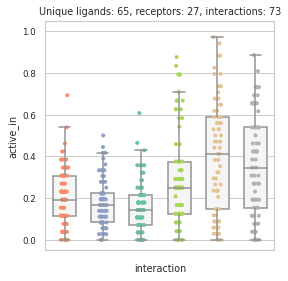

In [17]:

# Plot the boxplot

sns.set_theme(
            style='whitegrid',
            font_scale=0.8
            )
sns.set_palette(palette=sns.color_palette([region_colors_dict[r] for r in interact_with]))

fig, ax = plt.subplots(figsize=(4,4))
sns.stripplot(result_df,x='interaction',y='active_in',size=4,hue='interaction',ax=ax,legend=False)
sns.boxplot(showmeans=False,
        meanline=False,
        meanprops={'color': 'k', 'ls': '-', 'lw': 2},
        medianprops={'visible': True},
        whiskerprops={'visible': True},
        zorder=10,
        x="interaction",
        y="active_in",
        data=result_df,
        showfliers=False,
        showbox=True,
        showcaps=True,
        color='whitesmoke',
        width=0.6,
        ax=ax)

ax.set_ylim(-0.05,1.05)
ax.set_xticklabels('')
ax.set_title(title)

plt.tight_layout()
plt.savefig('./plots/receptor_ligand_interaction_analysis/Club_epithelium_as_target_ligrec_pct.pdf')
plt.show()

result_df['direction'] = 'club_as_target'
plot_df = pd.concat([plot_df,result_df],axis=0)
plot_df.to_excel('./source_data/figure_4g.xlsx')


In [18]:

result_df['n_interfaces_with_club'] = result_df['interaction'].map(n_interfaces)  # Add a column with info on the number of interfaces

# Calculate p-values for overrepresentation of individual ligand-receptor interactions
list_of_pvals = []
for i, row in result_df.iterrows():
    df = result_df[(result_df['ligand'] == row['ligand']) & (result_df['receptor'] == row['receptor'])]
    df = df[~(df['interaction'] ==row['interaction'])]

    a = row['active_in'] * row['n_interfaces_with_club']
    b = row['n_interfaces_with_club'] - a
    c = (df['active_in'] * df['n_interfaces_with_club']).sum()
    d = df['n_interfaces_with_club'].sum() - c

    arr = np.array([[a,b],[c,d]])
    arr

    stat, pval = fisher_exact(arr,alternative='greater')

    list_of_pvals.append(pval)

result_df['overrep_test_adj_pval'] = multipletests(list_of_pvals,method='fdr_bh')[1]

result_df = result_df.sort_values('overrep_test_adj_pval',ascending=True).reset_index(drop=True)

dict_with_final_ligrec_results['club_as_target'] = result_df

# Save the results
result_df.to_excel('./source_data/club_as_target_ligand_receptor_activity.xlsx')


In [19]:
# Perform Kruskal-Wallis H-test
interaction_categories = result_df['interaction'].unique()
grouped_data = [result_df[result_df['interaction'] == category]['active_in'] for category in interaction_categories]
test_statistic, p_value = kruskal(*grouped_data)
print(f"Kruskal-Wallis H-test: test statistic = {test_statistic:.4f}, p-value = {p_value:.4f}")


# Perform pairwise Wilcoxon rank-sums tests
interaction_categories = result_df['interaction'].unique()
pairwise_tests = list(combinations(interaction_categories, 2))

# Collect p-values and test statistics
test_results = []
for category1, category2 in pairwise_tests:
    group1 = result_df[result_df['interaction'] == category1]['active_in']
    group2 = result_df[result_df['interaction'] == category2]['active_in']
    test_statistic, p_value = ranksums(group1, group2)
    test_results.append({'Category1': category1, 'Category2': category2, 'stat': test_statistic, 'p-value': p_value})

# Create a dataframe from the test results
test_results = pd.DataFrame(test_results).sort_values('p-value').reset_index(drop=True)
print(test_results)


Kruskal-Wallis H-test: test statistic = 59.2094, p-value = 0.0000
             Category1           Category2      stat       p-value
0           Fibroblast    Basal epithelium  5.111546  3.195330e-07
1           Fibroblast  Luminal epithelium  5.027397  4.971817e-07
2               Muscle    Basal epithelium  4.923679  8.493209e-07
3   Luminal epithelium              Muscle -4.344423  1.396424e-05
4           Fibroblast               Tumor  4.272016  1.937140e-05
5               Immune    Basal epithelium  4.203523  2.627930e-05
6   Luminal epithelium              Immune -3.808219  1.399712e-04
7               Muscle               Tumor  3.616438  2.986844e-04
8               Immune               Tumor  2.788650  5.292828e-03
9     Basal epithelium               Tumor -2.146771  3.181151e-02
10          Fibroblast              Immune  1.780822  7.494155e-02
11  Luminal epithelium               Tumor -1.414873  1.571058e-01
12              Immune              Muscle -1.107632  2.680207e

In [82]:
# Save the results
pd.concat(club_as_target_ligrec).to_csv('./plots/receptor_ligand_interaction_analysis/{}_as_target_ligand_receptor_results.csv'.format(source.replace(' ','_')))

### Save both directions into a single excel table (Supplementary Table S9)

In [83]:
# Create a Pandas Excel writer using XlsxWriter as the engine
writer = pd.ExcelWriter('./supplementary_tables/club_regions_ligand_receptor_analysis.xlsx', engine='xlsxwriter')

# Write each dataframe to a different worksheet
for sheet_name, df in dict_with_final_ligrec_results.items():
    df.to_excel(writer, sheet_name=sheet_name, index=False)

# Close the Pandas Excel writer and output the Excel file
writer.save()

## Chord diagrams (Figure 4e, 4f)

In [ ]:
#from d3blocks import D3Blocks

# Get Club region degs
club_markers = check_top_markers('Club epithelium')['gene'].tolist()

### Club as source (Fig 4e)

In [ ]:
# Download from Supplementary Table S9
club_as_source = pd.read_excel('./supplementary_tables/club_regions_ligand_receptor_analysis.xlsx',sheet_name='club_as_source') 

club_as_source = club_as_source[club_as_source['ligand'].str.contains('CXCL|CCL')]
club_as_source = club_as_source.sort_values(['ligand','receptor'])

# Add the weight parameter ()
club_as_source['weight'] = club_as_source['active_in'] * club_as_source['n_interfaces_with_club']

# Concatenate into a single dataframe for plotting into a single Chord diagram
plot_df = club_as_source.groupby(['ligand','receptor']).sum().reset_index(['ligand','receptor'])[['ligand','receptor','weight']]
plot_df = plot_df.rename(columns={'ligand':'source','receptor':'target'})

plot_df.to_excel('./source_data/figure_4e.xlsx')

In [ ]:
# Plot
# Needs access to a browser due to how D3Blocks is built

d3 = D3Blocks()
d3.chord(plot_df,save_button=True,
color='source',
ordering=plot_df['source'].unique().tolist() + plot_df['target'].unique().tolist(),
title='From club to all',
fontsize=30,
cmap='viridis',
arrowhead=50
)


### Club as target (Fig 4f)

In [ ]:
# Download from Supplementary Table S9
club_as_target = pd.read_excel('./supplementary_tables/club_regions_ligand_receptor_analysis.xlsx',sheet_name='club_as_target')

# Plot the receptors that are within the top 100 of Club region markers
club_as_target = club_as_target[club_as_target['receptor'].isin(club_markers[:100])]
club_as_target = club_as_target.sort_values(['ligand','receptor'])

# Add the weight parameter ()
club_as_target['weight'] = club_as_target['active_in'] * club_as_target['n_interfaces_with_club']

# Concatenate into a single dataframe for plotting into a single Chord diagram
plot_df = club_as_target.groupby(['ligand','receptor']).sum().reset_index(['ligand','receptor'])[['ligand','receptor','weight']]
plot_df = plot_df.rename(columns={'ligand':'source','receptor':'target'})

plot_df.to_excel('./source_data/figure_4f.xlsx')

In [ ]:
# Plot
# Needs access to a browser due to how D3Blocks is built

d3 = D3Blocks()
d3.chord(plot_df,save_button=True,
color='target',
ordering=plot_df['source'].unique().tolist() + plot_df['target'].unique().tolist(),
title='From all to club',
fontsize=30,
cmap='viridis',
arrowhead=50
)
